# Graphical Representations of Data

Representing data graphically can be incredibly useful for learning how the data behaves and seeing potential structure or flaws. Care should be taken, as humans are incredibly good at seeing only evidence that confirms our beliefs, and visual data lends itself well to that. *Plots are good to use when formulating a hypothesis, but should not be used to test a hypothesis.*

We will go over some common plots here.

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

## Getting Some Data 

If we are going to plot data, we need some data to plot. We'll get the pricing of Apple (APPL) and Microsoft (MSFT) to use in our examples.

### Data Structure

Knowing the structure of our data is very important. Normally, we would have to do a ton of work molding our data into form we need for testing. In this case, the data return from `get_pricing()` function is of a Pandas `DataFrame` object. The rows are timestamps, and the columns are the two sets, APPL and MSFT.

In [1]:
# Mock implementation of get_pricing function
import pandas as pd
import yfinance as yf

_FIELD_MAP = {
    "price": "Close",        # Quantopian "price" ~= daily close
    "open_price": "Open",
    "high": "High",
    "low": "Low",
    "close_price": "Close",
    "volume": "Volume",
    "adj_close": "Adj Close",
}

def get_pricing(symbol, start_date, end_date, fields="price", adjusted=False):
    if isinstance(symbol, str):
        tickers = [symbol]
    else:
        tickers = list(symbol)

    col = _FIELD_MAP.get(fields, fields)

    df = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        interval="1d",
        auto_adjust=adjusted,
        actions=False,
        progress=False,
        group_by="ticker",
    )

    # Case 1: MultiIndex columns: (ticker, field)
    if isinstance(df.columns, pd.MultiIndex):
        # return Series for single ticker, DataFrame for multi tickers
        if len(tickers) == 1:
            t = tickers[0]
            if (t, col) not in df.columns:
                raise KeyError(f"Missing {(t, col)}. Available: {list(df.columns)}")
            out = df[(t, col)].copy()
            out.name = t
            return out
        else:
            out = {}
            for t in tickers:
                if (t, col) not in df.columns:
                    raise KeyError(f"Missing {(t, col)}. Available: {list(df.columns)[:10]} ...")
                out[t] = df[(t, col)]
            return pd.DataFrame(out)

    # Case 2: Flat columns: "Open", "High", ...
    else:
        if col not in df.columns:
            raise KeyError(f"Field '{fields}' mapped to '{col}' not found. Available: {list(df.columns)}")
        if len(tickers) == 1:
            out = df[col].copy()
            out.name = tickers[0]
            return out
        else:
            # In flat-column case with multiple tickers, yfinance usually returns MultiIndex,
            # but handle defensively anyway.
            return df[col].copy()

/Users/amourtu1934/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
# Get pricing data for AAPL and MSFT
start  = "2014-01-01"
end    = "2015-01-01"
data   = get_pricing(["AAPL", "MSFT"], start_date=start, end_date=end, fields="price", adjusted=False)
data.head(10)

,AAPL,MSFT
Date,,
2014-01-02,19.754642,37.160000
2014-01-03,19.320715,36.910000
2014-01-06,19.426071,36.130001
2014-01-07,19.287144,36.410000
2014-01-08,19.409286,35.759998
2014-01-09,19.161428,35.529999
2014-01-10,19.033571,36.040001
2014-01-13,19.133215,34.980000
2014-01-14,19.513929,35.779999


Indexing into the 2D dataframe will give us a 1D series object. The index for the series is timestampls, the value upon index is a price. Similar to an array, except instead of integer, indices are times.

In [10]:
data["MSFT"].head(10)

Date
2014-01-02    37.160000
2014-01-03    36.910000
2014-01-06    36.130001
2014-01-07    36.410000
2014-01-08    35.759998
2014-01-09    35.529999
2014-01-10    36.040001
2014-01-13    34.980000
2014-01-14    35.779999
2014-01-15    36.759998
Name: MSFT, dtype: float64

## Histogram

A *histogram* is a visualization of how frequent different values of data are. By displaying a frequency distribution using bars, it lets us quickly see where most of the observations are clustered. The height of each bar represents the number of observations that lie in each interval. Think of this as an empirical and discrete Probability Density Function (PDF).

Text(0.5, 1.0, 'Frequency Distribution of MSFT Prices (2014)')

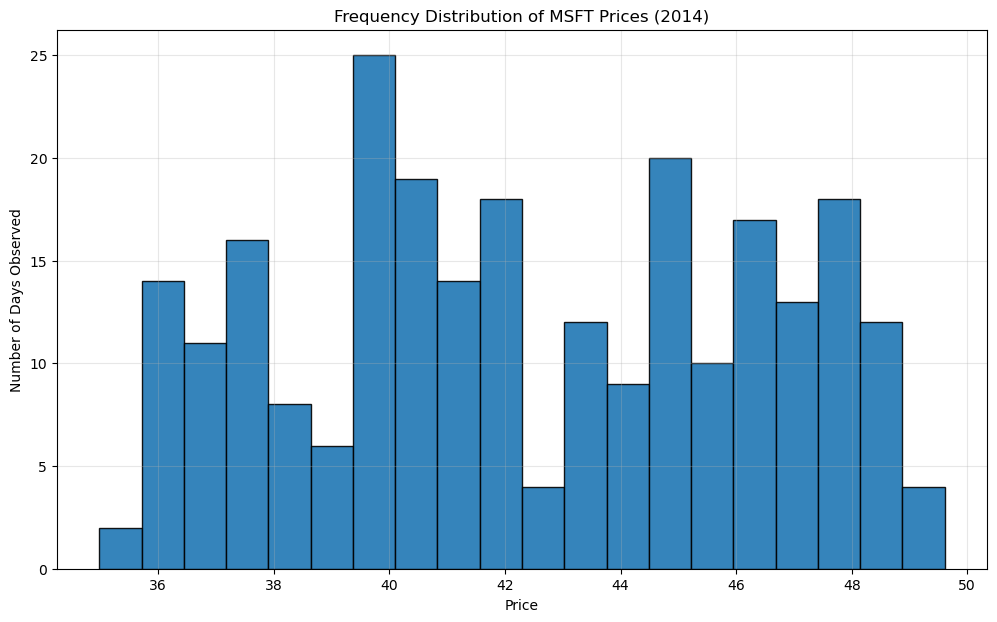

In [18]:
# Plot a histogram using 20 bins
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.hist(data["MSFT"], bins=20, edgecolor="black", alpha=0.9)
plt.xlabel("Price")
plt.ylabel("Number of Days Observed")
plt.title("Frequency Distribution of MSFT Prices (2014)")

### Return Histogram

In finance, rarely will we look at the distribution of prices. The reason for this is that prices are non-stationary and move around a lot. Instead, we will use *daily returns*. Let's try that now.

Text(0.5, 1.0, 'Frequency Distribution of MSFT Daily Returns (2014)')

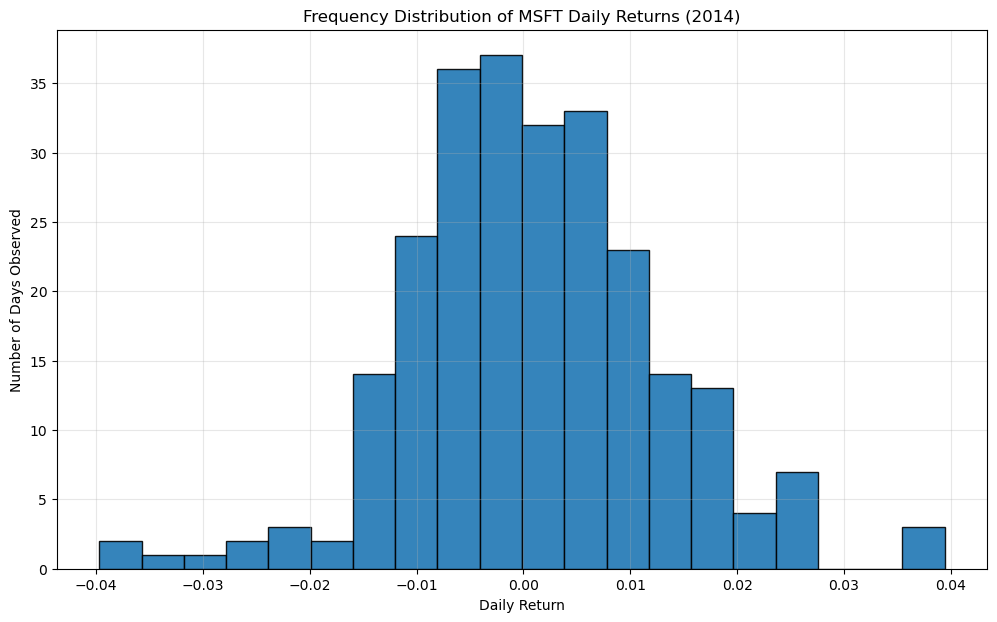

In [21]:
# Remove the first element because the price change from nothing to something is NaN
R = data["MSFT"].pct_change()[1:]

# Plot a histogram of daily returns using 20 bins
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.hist(R, bins=20, edgecolor="black", alpha=0.9)
plt.xlabel("Daily Return")
plt.ylabel("Number of Days Observed")
plt.title("Frequency Distribution of MSFT Daily Returns (2014)")

The graph above shows that the daily returns of MSFT were above 0.03 on fewer than 5 days in 2014. Note that we completely discard the dates corresponding to those returns.

**IMPORTANT**: Note also that this does not imply that future returns will have the same distribution.

## Cumulative Histogram (Discrete Estimated CDF)

An alternative way to display the data would be using a cumulative distribution function, in which the the height of a bar represents the number of observations that lie in that bin or in one of the preious ones. This graph is always nondecreasing since we cannot have a negative number of observations. The choice of graph depends on the information that we are interested in.

Text(0.5, 1.0, 'Cumulative Frequency Distribution of MSFT Daily Returns (2014)')

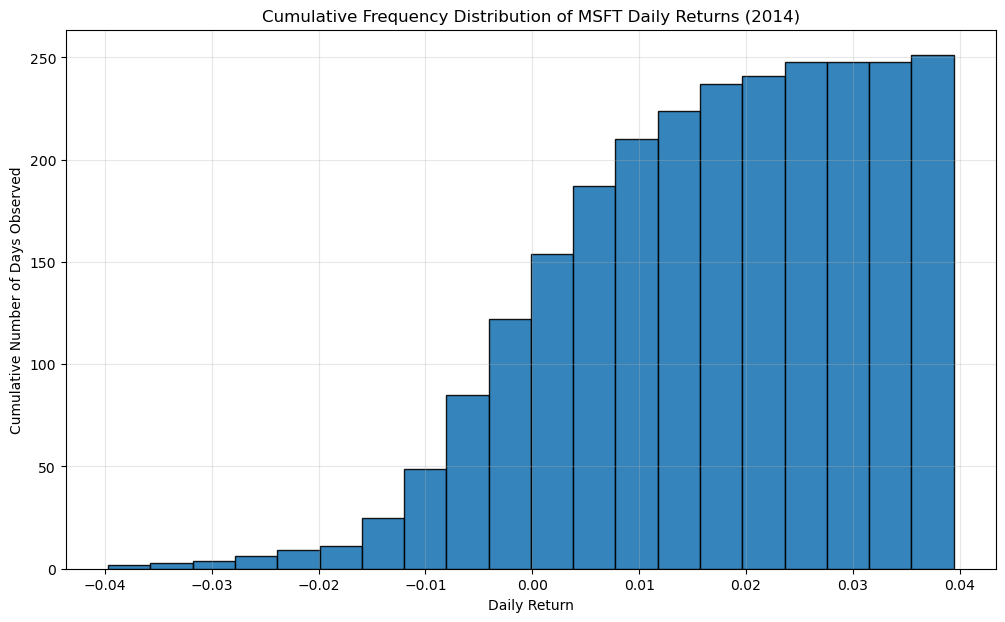

In [24]:
# Plot a cumulative histogram using 20 bins
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.hist(R, bins=20, edgecolor="black", alpha=0.9, cumulative=True)
plt.xlabel("Daily Return")
plt.ylabel("Cumulative Number of Days Observed")
plt.title("Cumulative Frequency Distribution of MSFT Daily Returns (2014)")

## Scatter Plot

A *scatter plot* is useful for visualizing the relationship between two datasets. We use two datasets which have some sort of correspondence, such as the date on which the measurement was taken. Each point represents two corresponding values form the two datasets. However, we don't plot the date that the measurements were taken on.

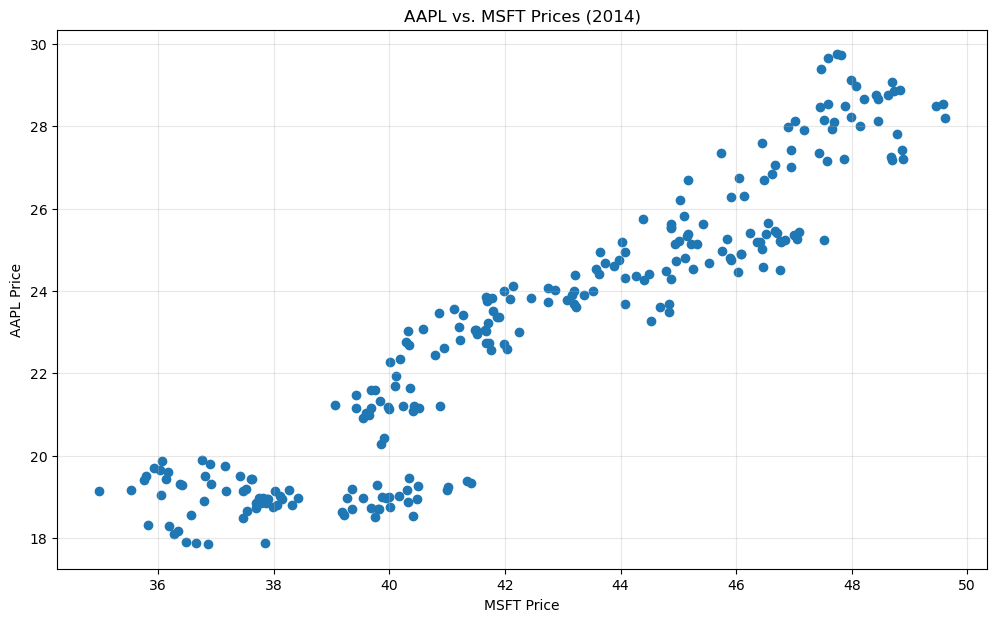

In [31]:
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.scatter(data["MSFT"], data["AAPL"])
plt.xlabel("MSFT Price")
plt.ylabel("AAPL Price")
plt.title("AAPL vs. MSFT Prices (2014)");

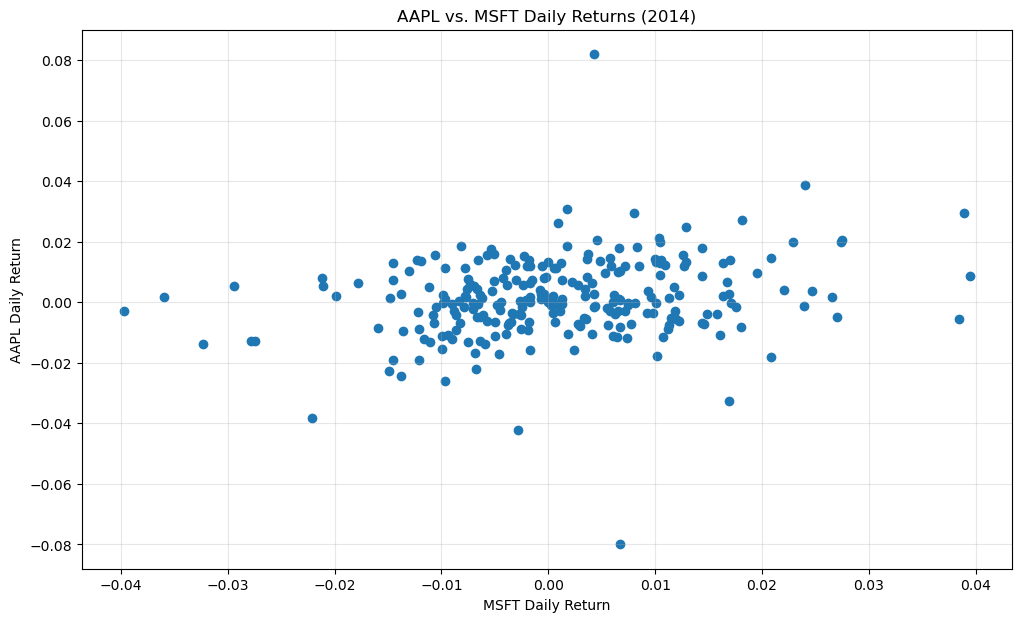

In [27]:
# Calculate daily returns for MSFT and AAPL
R_msft = data["MSFT"].pct_change()[1:]
R_aapl = data["AAPL"].pct_change()[1:]

# Scatter plot of daily returns
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.scatter(R_msft, R_aapl)
plt.xlabel("MSFT Daily Return")
plt.ylabel("AAPL Daily Return")
plt.title("AAPL vs. MSFT Daily Returns (2014)");

## Line Graph

A *line graph* can be used when we want to track the development of the y value as the x value changes. For instance, when we are plotting the price of a stock, showing it as a line graph instead of just plotting the data points makes it easier to follow the price over time. This necessarily involves "connecting the dots" between the data points, which can mask out changes that happened between the time we took the measurements.

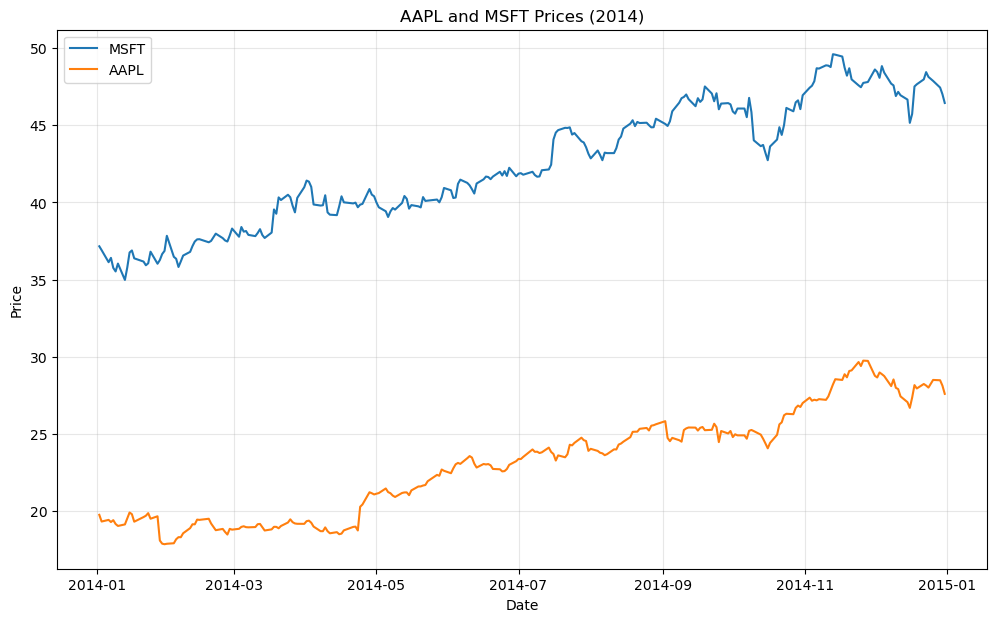

In [35]:
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.plot(data["MSFT"], label="MSFT")
plt.plot(data["AAPL"], label="AAPL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AAPL and MSFT Prices (2014)")
plt.legend();

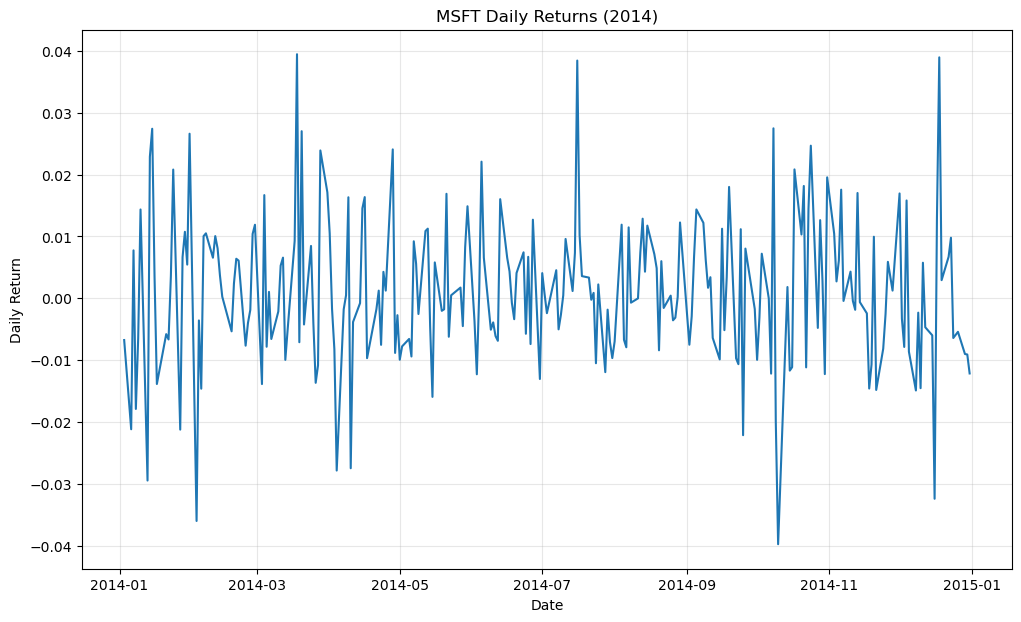

In [40]:
# Line plot of MSFT and AAPL daily returns
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.plot(R)
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("MSFT Daily Returns (2014)");

## Never Assume Conditions Hold

Again, whenever using plots to visualize data, do not assume we can test a hypothesis by looking at a graph. Also do not assume that because a distribution or trend used to be true, it is still true. In general, much more sophisticated and careful validation is required to test whether models hold. Plots are mainly useful when initially deciding how our models should work.